In [4]:
import dask.dataframe as dd
import pandas as pd
import ray.dataframe as rd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
os.chdir("/Users/bshao/Desktop/lending club")

In [14]:
loan_15 = pd.read_csv("LoanStats3d.csv",sep=",",encoding="latin-1")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (17,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
loan_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Columns: 143 entries, loan_amnt to settlement_term
dtypes: float64(66), int64(40), object(37)
memory usage: 459.4+ MB


In [12]:
loan_15.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,9000,9000,9000.0,36 months,8.49%,284.07,B,B1,Office Manager,8 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,17475,17475,17475.0,36 months,13.99%,597.17,C,C4,Software Testing Analyst,2 years,...,NaN,NaN,Cash,Y,Jan-18,ACTIVE,Jan-18,4382.0,44.99,12.0
2,21000,21000,21000.0,60 months,13.99%,488.53,C,C4,Resident physician,< 1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,7200,7200,7200.0,36 months,11.48%,237.36,B,B5,Legal Administrative Assistant,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,27500,27500,27500.0,60 months,14.85%,652.06,C,C5,Manager,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,7000,7000,7000.0,36 months,7.49%,217.72,A,A4,Carrier,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6,16800,16800,16800.0,60 months,12.88%,381.23,C,C2,CEO,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7,17925,17925,17925.0,60 months,17.27%,448.09,D,D3,IT Help Desk Support,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
8,29900,29900,29900.0,60 months,12.88%,678.49,C,C2,Corporate Insurance,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
9,28000,28000,28000.0,60 months,14.85%,663.92,C,C5,Division General Manager,2 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
loan_15.loan_status.value_counts()

Fully Paid            183593
Current               165977
Charged Off            62042
Late (31-120 days)      5485
In Grace Period         2943
Late (16-30 days)       1033
Default                   22
Name: loan_status, dtype: int64

In [27]:
ddf = dd.read_csv("LoanStats3d.csv",encoding="latin-1",dtype="str")

In [28]:
ddf.loan_status.value_counts().compute()

Fully Paid            183593
Current               165977
Charged Off            62042
Late (31-120 days)      5485
In Grace Period         2943
Late (16-30 days)       1033
Default                   22
Name: loan_status, dtype: int64

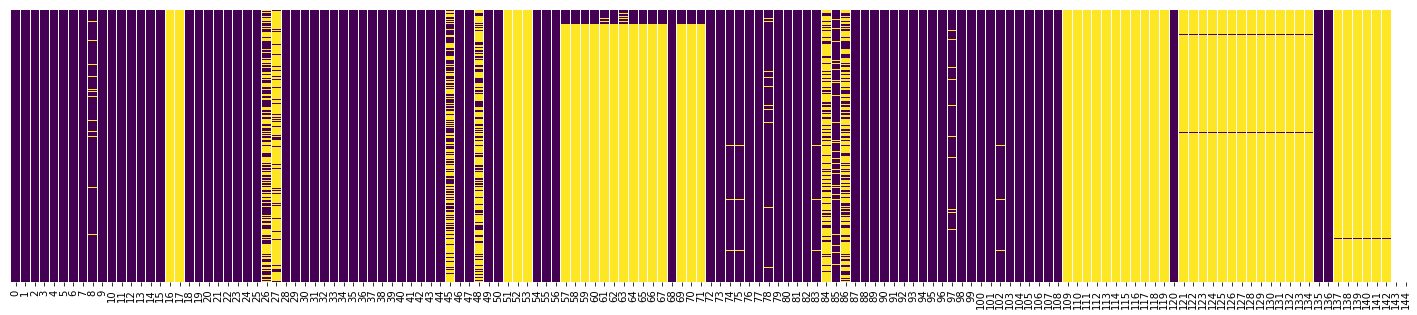

In [29]:
plt.figure(figsize=(25,5)) 
sns.set_context(font_scale=10)   
sns.heatmap(loan_15.isnull(),yticklabels=False,cbar=False,cmap='viridis',xticklabels=list(range(145)))

In [53]:
missing = pd.DataFrame(loan_15.isnull().sum()/len(loan_15),columns=['%missing_value']).sort_values(by='%missing_value',ascending=False)

In [59]:
missing[missing['%missing_value']<0.5].index

Index(['mths_since_last_delinq', 'mths_since_recent_inq', 'emp_title',
       'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'percent_bc_gt_75', 'bc_util',
       'bc_open_to_buy', 'mths_since_recent_bc', 'last_pymnt_d', 'revol_util',
       'title', 'last_credit_pull_d', 'dti', 'num_rev_accts', 'revol_bal',
       'pub_rec', 'open_acc', 'total_acc', 'initial_list_status',
       'inq_last_6mths', 'earliest_cr_line', 'total_il_high_credit_limit',
       'total_bc_limit', 'total_bal_ex_mort', 'tot_hi_cred_lim',
       'application_type', 'delinq_2yrs', 'emp_length', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'debt_settlement_flag',
       'disbursement_method', 'sub_grade', 'home_ownership', 'hardship_flag',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'tax_liens', 'addr_state', 'zip_code',
       'num_sats', 'pub_rec_bankruptcies', 'total_rec_int', 'funded_amnt',
       'out_prncp', 'out_prncp_inv', 'total_r

In [36]:
rdf.isnull().sum()[rdf.isnull().sum()>30000].index.tolist()

['emp_title',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']